Generate plots based on parametric dataset (var alpha, fr and tau, 100 000 signals, 10 min length, spike_trains_3params_var_len600sec_100000.pkl)

In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import joypy

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'results\\synthetic\\dataset\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'
fig_folder = project_folder_path + 'results\\synthetic\\fig_drafts_paper\\'

In [32]:
save_fig = True

### Load data

In [4]:
with open(dataset_folder + '1_spike_trains_3params_var_len600sec_100000.pkl','rb') as f:
    data = pickle.load(f)

spike_trains = data['spike_trains']
alphas = data['alphas']
fr_values = data['fr_values']
taus_ms = data['tau_ms']
duration_ms = data['duration_ms']

print(f'n spike trains {len(spike_trains)}, len {spike_trains[0][-1]/1000}, duration_ms {duration_ms}')

fs = 1000

n spike trains 100000, len 598.8243581617338, duration_ms 600000


In [6]:
with open(results_folder + 'acf_isttc_full_50ms_20lags_dict.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

with open(results_folder + 'acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

with open(results_folder + 'pearsonr_trial_avg_50ms_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_avg_50ms_dict.pkl', "rb") as f:
    sttc_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_concat_50ms_dict.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

print(f'len isttc_full_dict {len(isttc_full_dict)}')
print(f'len acf_full_dict {len(acf_full_dict)}')
print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
print(f'len sttc_trial_avg_dict {len(sttc_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')

len isttc_full_dict 100000
len acf_full_dict 100000
len pearsonr_trial_avg_dict 100000
len sttc_trial_avg_dict 100000
len sttc_trial_concat_dict 100000


### Make summary dfs

In [7]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [8]:
def get_trials_plot_df(trial_dict_, method_, n_iteration_=None):
    records = []
    for unit_id, data in trial_dict_.items():
        taus = data['taus']
        acfs = data['acf']

        if n_iteration_ is not None:
            # only one trial per unit
            idx = n_iteration_[unit_id]
            taus_to_iter = [(taus[idx], acfs[idx])]
        else:
            # all trials for this unit
            taus_to_iter = zip(taus, acfs)

        for tau_dict, acf_array in taus_to_iter:
            records.append({
                'unit_id': unit_id,
                'tau': tau_dict['tau'],
                'fit_r_squared': tau_dict['fit_r_squared'],
                'decline_150_250': calculate_acf_decline_flag(acf_array, start_idx=2, end_idx=4),
                'method': method_,
            })

    df = pd.DataFrame.from_records(records)
    df['tau_ms'] = df['tau'] * 50

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}')

    return df

In [10]:
# for trial based measures one realization of trials is taken
random_trials_impl = np.zeros(len(sttc_trial_concat_dict)).astype(int)

pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg', random_trials_impl)
sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat', random_trials_impl)
sttc_trial_avg_plot_df = get_trials_plot_df(sttc_trial_avg_dict, 'sttc_trial_avg', random_trials_impl)

pearsontr_trial_avg_plot_df['fr'] = fr_values
pearsontr_trial_avg_plot_df['alpha'] = alphas
pearsontr_trial_avg_plot_df['tau_ms_true'] = taus_ms
pearsontr_trial_avg_plot_df['tau_diff_abs'] = np.abs(pearsontr_trial_avg_plot_df['tau_ms'] - pearsontr_trial_avg_plot_df['tau_ms_true'])
pearsontr_trial_avg_plot_df['tau_diff_rel'] = pearsontr_trial_avg_plot_df['tau_diff_abs'] / pearsontr_trial_avg_plot_df['tau_ms_true'] * 100

sttc_trial_concat_plot_df['fr'] = fr_values
sttc_trial_concat_plot_df['alpha'] = alphas
sttc_trial_concat_plot_df['tau_ms_true'] = taus_ms
sttc_trial_concat_plot_df['tau_diff_abs'] = np.abs(sttc_trial_concat_plot_df['tau_ms'] - sttc_trial_concat_plot_df['tau_ms_true'])
sttc_trial_concat_plot_df['tau_diff_rel'] = sttc_trial_concat_plot_df['tau_diff_abs'] / sttc_trial_concat_plot_df['tau_ms_true'] * 100

sttc_trial_avg_plot_df['fr'] = fr_values
sttc_trial_avg_plot_df['alpha'] = alphas
sttc_trial_avg_plot_df['tau_ms_true'] = taus_ms
sttc_trial_avg_plot_df['tau_diff_abs'] = np.abs(sttc_trial_avg_plot_df['tau_ms'] - sttc_trial_avg_plot_df['tau_ms_true'])
sttc_trial_avg_plot_df['tau_diff_rel'] = sttc_trial_avg_plot_df['tau_diff_abs'] / sttc_trial_avg_plot_df['tau_ms_true'] * 100

N rows with NaNs 12393


In [11]:
# check for NaNs and for a long df remove rows with NaNs (if for a unit one method failed than remove it)

rows_with_nans_pearsonr_df = pearsontr_trial_avg_plot_df[pearsontr_trial_avg_plot_df.isna().any(axis=1)]
n_rows_with_nan_pearsonr = len(rows_with_nans_pearsonr_df)
print(f'N rows with NaNs {n_rows_with_nan_pearsonr}')

rows_with_nans_isttc_concat_df = sttc_trial_concat_plot_df[sttc_trial_concat_plot_df.isna().any(axis=1)]
n_rows_with_nan_isttc_concat = len(rows_with_nans_isttc_concat_df)
print(f'N rows with NaNs {n_rows_with_nan_isttc_concat}')

rows_with_nans_isttc_avg_df = sttc_trial_avg_plot_df[sttc_trial_avg_plot_df.isna().any(axis=1)]
n_rows_with_nan_isttc_avg = len(rows_with_nans_isttc_avg_df)
print(f'N rows with NaNs {n_rows_with_nan_isttc_avg}')

pearsonr_nan_unit_ids = rows_with_nans_pearsonr_df['unit_id'].values
sttc_concat_nan_unit_ids = rows_with_nans_isttc_concat_df['unit_id'].values
sttc_avg_nan_unit_ids = rows_with_nans_isttc_avg_df['unit_id'].values

unit_ids_nan_union = set(pearsonr_nan_unit_ids).union(sttc_concat_nan_unit_ids).union(sttc_avg_nan_unit_ids)
print(f'N rows in unit_ids_nan_union {len(unit_ids_nan_union)}')

# take rows without NaNs
pearsonr_sans_nans_plot_df = pearsontr_trial_avg_plot_df[~pearsontr_trial_avg_plot_df['unit_id'].isin(unit_ids_nan_union)]
sttc_concat_sans_nans_plot_df = sttc_trial_concat_plot_df[~sttc_trial_concat_plot_df['unit_id'].isin(unit_ids_nan_union)]
sttc_avg_sans_nans_plot_df = sttc_trial_avg_plot_df[~sttc_trial_avg_plot_df['unit_id'].isin(unit_ids_nan_union)]

print(f'len pearsonr {len(pearsonr_sans_nans_plot_df)}, len sttc_concat {len(sttc_concat_sans_nans_plot_df)}, len sttc_avg {len(sttc_avg_sans_nans_plot_df)}')

N rows with NaNs 12393
N rows with NaNs 0
N rows with NaNs 0
N rows in unit_ids_nan_union 12393
len pearsonr 87607, len sttc_concat 87607, len sttc_avg 87607


In [14]:
# check for negative R-square

rows_with_negr_pearsonr_df = pearsonr_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_pearsonr = len(rows_with_negr_pearsonr_df)
print(f'N rows with neg R {n_rows_with_negr_pearsonr}')

rows_with_negr_isttc_concat_df = sttc_concat_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc_concat = len(rows_with_negr_isttc_concat_df)
print(f'N rows with neg R {n_rows_with_negr_isttc_concat}')

rows_with_negr_isttc_avg_df = sttc_avg_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc_avg = len(rows_with_negr_isttc_avg_df)
print(f'N rows with neg R {n_rows_with_negr_isttc_avg}')

pearsonr_negr_unit_ids = rows_with_negr_pearsonr_df['unit_id'].values
isttc_concat_negr_unit_ids = rows_with_negr_isttc_concat_df['unit_id'].values
isttc_avg_negr_unit_ids = rows_with_negr_isttc_avg_df['unit_id'].values

unit_ids_negr_union = set(pearsonr_negr_unit_ids).union(isttc_concat_negr_unit_ids).union(isttc_avg_negr_unit_ids)
print(f'N rows in unit_ids_negr_union {len(unit_ids_negr_union)}')

pearsonr_sans_negr_plot_df = pearsonr_sans_nans_plot_df[~pearsonr_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
sttc_concat_sans_negr_plot_df = sttc_concat_sans_nans_plot_df[~sttc_concat_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
sttc_avg_sans_negr_plot_df = sttc_avg_sans_nans_plot_df[~sttc_avg_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()

pearsonr_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(pearsonr_sans_negr_plot_df['tau_diff_rel'])
sttc_concat_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(sttc_concat_sans_negr_plot_df['tau_diff_rel'])
sttc_avg_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(sttc_avg_sans_negr_plot_df['tau_diff_rel'])

print(f'len pearsonr {len(pearsonr_sans_negr_plot_df)}, len sttc_concat {len(sttc_concat_sans_negr_plot_df)}, len sttc_avg {len(sttc_avg_sans_negr_plot_df)}')

N rows with neg R 4201
N rows with neg R 4295
N rows with neg R 4479
N rows in unit_ids_negr_union 6658
len pearsonr 80949, len sttc_concat 80949, len sttc_avg 80949


In [15]:
tau_plot_long_df = pd.concat([pearsonr_sans_negr_plot_df, 
                              sttc_concat_sans_negr_plot_df, 
                              sttc_avg_sans_negr_plot_df])
tau_plot_long_df['log_tau_ms'] = np.log10(tau_plot_long_df['tau_ms'])
tau_plot_long_df.reset_index(inplace=True, drop=True)

print(f'len tau_plot_long_df {len(tau_plot_long_df)}')

tau_plot_long_df.head(3)

len tau_plot_long_df 242847


,unit_id,tau,fit_r_squared,decline_150_250,method,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,tau_diff_rel_log10,log_tau_ms
0,0,5.054998,0.972005,True,pearsonr_trial_avg,252.749919,7.741821,0.851099,150.923515,101.826404,67.468879,1.829103,2.402691
1,1,2.020436,0.944998,True,pearsonr_trial_avg,101.021800,4.394396,0.858098,147.947233,46.925433,31.717682,1.501301,2.004415
2,2,79.998685,0.773955,True,pearsonr_trial_avg,3999.934263,8.587393,0.528805,267.002290,3732.931973,1398.089874,3.145535,3.602053


In [21]:
tau_plot_wide_pearsonr_concat_df = pearsonr_sans_negr_plot_df.merge(sttc_concat_sans_negr_plot_df, 
                                                                    suffixes=('_pearsonr', '_sttc_concat'), 
                                                                    on=['unit_id','fr', 'alpha', 'tau_ms_true'], how='left')
tau_plot_wide_pearsonr_concat_df.reset_index(inplace=True, drop=True)

print(f'len tau_plot_wide_pearsonr_concat_df {len(tau_plot_wide_pearsonr_concat_df)}')

tau_plot_wide_pearsonr_concat_df.columns

len tau_plot_wide_pearsonr_concat_df 80949


Index(['unit_id', 'tau_pearsonr', 'fit_r_squared_pearsonr',
       'decline_150_250_pearsonr', 'method_pearsonr', 'tau_ms_pearsonr', 'fr',
       'alpha', 'tau_ms_true', 'tau_diff_abs_pearsonr',
       'tau_diff_rel_pearsonr', 'tau_diff_rel_log10_pearsonr',
       'tau_sttc_concat', 'fit_r_squared_sttc_concat',
       'decline_150_250_sttc_concat', 'method_sttc_concat',
       'tau_ms_sttc_concat', 'tau_diff_abs_sttc_concat',
       'tau_diff_rel_sttc_concat', 'tau_diff_rel_log10_sttc_concat'],
      dtype='object')

In [28]:
tau_plot_wide_pearsonr_avg_df = pearsonr_sans_negr_plot_df.merge(sttc_avg_sans_negr_plot_df, 
                                                                    suffixes=('_pearsonr', '_sttc_avg'), 
                                                                    on=['unit_id','fr', 'alpha', 'tau_ms_true'], how='left')
tau_plot_wide_pearsonr_avg_df.reset_index(inplace=True, drop=True)

print(f'len tau_plot_wide_pearsonr_avg_df {len(tau_plot_wide_pearsonr_avg_df)}')

len tau_plot_wide_pearsonr_avg_df 80949


### Export for stats

In [16]:
tau_plot_long_df.to_csv(results_folder + 'tau_plot_long_trails_df.csv')

### Plots

In [18]:
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_avg =  '#a49fce' 
color_sttc_trail_concat = '#955da2' 

colors = [color_pearson_trail_avg, color_sttc_trail_avg, color_sttc_trail_concat]

In [ ]:
#tau_plot_long_df = pd.read_pickle()

In [27]:
tau_plot_long_df.groupby(by='method', as_index=False)['tau_diff_rel'].median()

,method,tau_diff_rel
0,pearsonr_trial_avg,57.859677
1,sttc_trial_avg,58.588293
2,sttc_trial_concat,54.811468


In [17]:
tau_plot_long_df['tau_diff_rel_log10'] = np.log10(tau_plot_long_df['tau_diff_rel'])

<Axes: xlabel='tau_diff_rel_log10', ylabel='Density'>

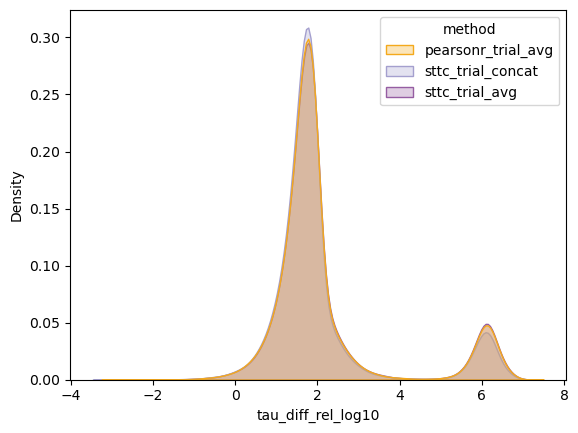

In [19]:
sns.kdeplot(
    data=tau_plot_long_df, 
    x="tau_diff_rel_log10", 
    hue="method",
    fill=True, 
    alpha=0.3,
    palette=colors
)

3.3585661122215154
3.36406953604485
3.36406953604485


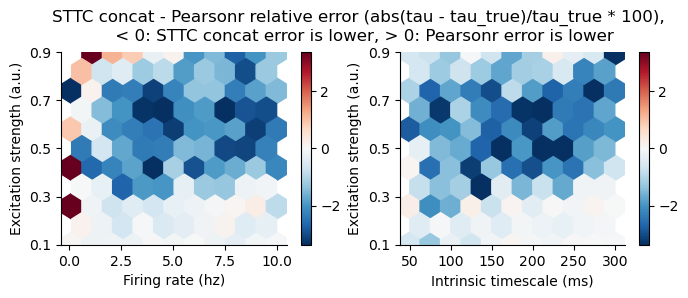

In [33]:
fig, axes = plt.subplots(1,2, figsize=(8,2.5))

norm = TwoSlopeNorm(vcenter=0)

hb0 = axes[0].hexbin(
    x=tau_plot_wide_pearsonr_concat_df['fr'], y=tau_plot_wide_pearsonr_concat_df['alpha'],
    C=tau_plot_wide_pearsonr_concat_df['tau_diff_rel_sttc_concat'] - tau_plot_wide_pearsonr_concat_df['tau_diff_rel_pearsonr'],
    reduce_C_function=np.median,   
    gridsize=10,                
    cmap='RdBu_r',
    norm = norm,
    mincnt=1                    
)

p95_hb0 = np.percentile(np.abs(hb0.get_array()), 95)
print(p95_hb0)

hb1 = axes[1].hexbin(
    x=tau_plot_wide_pearsonr_concat_df['tau_ms_true'], y=tau_plot_wide_pearsonr_concat_df['alpha'],
    C=tau_plot_wide_pearsonr_concat_df['tau_diff_rel_sttc_concat'] - tau_plot_wide_pearsonr_concat_df['tau_diff_rel_pearsonr'],
    reduce_C_function=np.median,   
    gridsize=10,                
    cmap='RdBu_r',
    norm = norm,
    mincnt=1   
)

p95_hb1 = np.percentile(np.abs(hb1.get_array()), 95)
print(p95_hb1)

bar_lim = np.max([p95_hb0, p95_hb1])

hb0.set_clim(-bar_lim, bar_lim)
hb1.set_clim(-bar_lim, bar_lim)
print(bar_lim)

fig.colorbar(hb0, ax=axes[0], shrink=1)
fig.colorbar(hb1, ax=axes[1], shrink=1)

axes[0].set_xlabel('Firing rate (hz)')
axes[1].set_xlabel('Intrinsic timescale (ms)')
axes[1].set_xticks(np.linspace(50, 300, 6))

fig.suptitle('STTC concat - Pearsonr relative error (abs(tau - tau_true)/tau_true * 100), \n < 0: STTC concat error is lower, > 0: Pearsonr error is lower', y=1.05)

for ax in axes.flat:
    sns.despine(ax=ax)
    ax.set_ylabel('Excitation strength (a.u.)')
    ax.set_ylim([0.1, 0.9])
    ax.set_yticks(np.linspace(0.1, 0.9, 5))

if save_fig:
    plt.savefig(fig_folder + 'taus_dataset_3_var_rel_diff_trials_perasonr_concat.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_dataset_3_var_rel_diff_trials_perasonr_concat.svg' , bbox_inches='tight')

1.900597358824091
1.3458863238116674
1.900597358824091


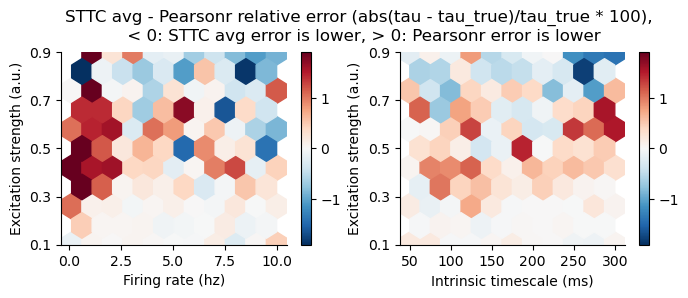

In [34]:
fig, axes = plt.subplots(1,2, figsize=(8,2.5))

norm = TwoSlopeNorm(vcenter=0)

hb0 = axes[0].hexbin(
    x=tau_plot_wide_pearsonr_avg_df['fr'], y=tau_plot_wide_pearsonr_avg_df['alpha'],
    C=tau_plot_wide_pearsonr_avg_df['tau_diff_rel_sttc_avg'] - tau_plot_wide_pearsonr_avg_df['tau_diff_rel_pearsonr'],
    reduce_C_function=np.median,   
    gridsize=10,                
    cmap='RdBu_r',
    norm = norm,
    mincnt=1                    
)

p95_hb0 = np.percentile(np.abs(hb0.get_array()), 95)
print(p95_hb0)

hb1 = axes[1].hexbin(
    x=tau_plot_wide_pearsonr_avg_df['tau_ms_true'], y=tau_plot_wide_pearsonr_avg_df['alpha'],
    C=tau_plot_wide_pearsonr_avg_df['tau_diff_rel_sttc_avg'] - tau_plot_wide_pearsonr_avg_df['tau_diff_rel_pearsonr'],
    reduce_C_function=np.median,   
    gridsize=10,                
    cmap='RdBu_r',
    norm = norm,
    mincnt=1   
)

p95_hb1 = np.percentile(np.abs(hb1.get_array()), 95)
print(p95_hb1)

bar_lim = np.max([p95_hb0, p95_hb1])

hb0.set_clim(-bar_lim, bar_lim)
hb1.set_clim(-bar_lim, bar_lim)
print(bar_lim)

fig.colorbar(hb0, ax=axes[0], shrink=1)
fig.colorbar(hb1, ax=axes[1], shrink=1)

axes[0].set_xlabel('Firing rate (hz)')
axes[1].set_xlabel('Intrinsic timescale (ms)')
axes[1].set_xticks(np.linspace(50, 300, 6))

fig.suptitle('STTC avg - Pearsonr relative error (abs(tau - tau_true)/tau_true * 100), \n < 0: STTC avg error is lower, > 0: Pearsonr error is lower', y=1.05)

for ax in axes.flat:
    sns.despine(ax=ax)
    ax.set_ylabel('Excitation strength (a.u.)')
    ax.set_ylim([0.1, 0.9])
    ax.set_yticks(np.linspace(0.1, 0.9, 5))

if save_fig:
    plt.savefig(fig_folder + 'taus_dataset_3_var_rel_diff_trials_perasonr_avg.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_dataset_3_var_rel_diff_trials_perasonr_avg.svg' , bbox_inches='tight')

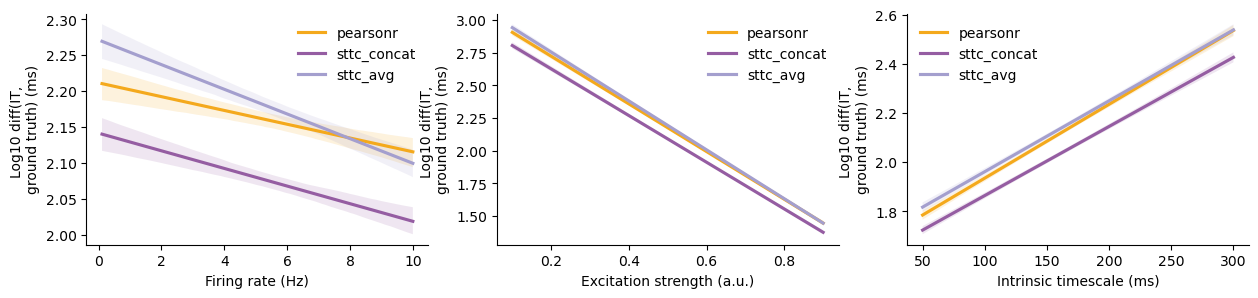

In [35]:
fig, axes = plt.subplots(1,3, figsize=(15, 3), sharey=False)

sns.regplot(x=tau_plot_wide_pearsonr_concat_df['fr'].values, y=np.log10(tau_plot_wide_pearsonr_concat_df['tau_diff_rel_pearsonr']), scatter=None, ax=axes[0], 
            label='pearsonr', color=color_pearson_trail_avg)
sns.regplot(x=tau_plot_wide_pearsonr_concat_df['fr'].values, y=np.log10(tau_plot_wide_pearsonr_concat_df['tau_diff_rel_sttc_concat']), scatter=None, ax=axes[0], 
            label='sttc_concat', color=color_sttc_trail_concat)
sns.regplot(x=tau_plot_wide_pearsonr_avg_df['fr'].values, y=np.log10(tau_plot_wide_pearsonr_avg_df['tau_diff_rel_sttc_avg']), scatter=None, ax=axes[0], 
            label='sttc_avg', color=color_sttc_trail_avg)
axes[0].legend(frameon=False)

sns.regplot(x=tau_plot_wide_pearsonr_concat_df['alpha'].values, y=np.log10(tau_plot_wide_pearsonr_concat_df['tau_diff_rel_pearsonr']), scatter=None, ax=axes[1], 
            label='pearsonr', color=color_pearson_trail_avg)
sns.regplot(x=tau_plot_wide_pearsonr_concat_df['alpha'].values, y=np.log10(tau_plot_wide_pearsonr_concat_df['tau_diff_rel_sttc_concat']), scatter=None, ax=axes[1], 
            label='sttc_concat', color=color_sttc_trail_concat)
sns.regplot(x=tau_plot_wide_pearsonr_avg_df['alpha'].values, y=np.log10(tau_plot_wide_pearsonr_avg_df['tau_diff_rel_sttc_avg']), scatter=None, ax=axes[1], 
            label='sttc_avg', color=color_sttc_trail_avg)
axes[1].legend(frameon=False)

sns.regplot(x=tau_plot_wide_pearsonr_concat_df['tau_ms_true'].values, y=np.log10(tau_plot_wide_pearsonr_concat_df['tau_diff_rel_pearsonr']), scatter=None, ax=axes[2], 
            label='pearsonr', color=color_pearson_trail_avg)
sns.regplot(x=tau_plot_wide_pearsonr_concat_df['tau_ms_true'].values, y=np.log10(tau_plot_wide_pearsonr_concat_df['tau_diff_rel_sttc_concat']), scatter=None, ax=axes[2], 
            label='sttc_concat', color=color_sttc_trail_concat)
sns.regplot(x=tau_plot_wide_pearsonr_avg_df['tau_ms_true'].values, y=np.log10(tau_plot_wide_pearsonr_avg_df['tau_diff_rel_sttc_avg']), scatter=None, ax=axes[2], 
            label='sttc_avg', color=color_sttc_trail_avg)
axes[2].legend(frameon=False)


axes[0].set_xlabel('Firing rate (Hz)')
axes[1].set_xlabel('Excitation strength (a.u.)')
axes[2].set_xlabel('Intrinsic timescale (ms)')

for ax in axes.flat:
    ax.set_ylabel('Log10 diff(IT, \nground truth) (ms)')

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'taus_dataset_fr_alpha_var_diff_regplot_trials.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_dataset_fr_alpha_var_diff_regplot_trials.svg' , bbox_inches='tight')